Creation of a recommendation system: Students will create a simple recommendation system using a dataset of film or book ratings available online (e.g. the MovieLens dataset). The system will suggest new items to users based on their previous ratings.

- Pro: allows for working with recommendation algorithms and collaborative filtering.
- Cons: may require an introduction to recommendation algorithms.

## Frame the Problem

I decided to create my own dataset instead of using the existing one.

My project recommends board games for a user from https://boardgamegeek.com/.
**The idea**: you enter your username, and the recommendation system provides you a list of recommendations.
 


### Import Libraries

In [8]:
import requests
from time import sleep
from bs4 import BeautifulSoup
import scipy.io
import matplotlib.pyplot as plt
import matplotlib 
import pandas as pd
import numpy as np

import timeit
import re

## Scaping
It turned out, that the scaping was not an easy task.

### Scrape a list of 1000 games
There are 145K+ games on 1453 pages.
I decided to scrape the first 1000 games (based on their *Geek Rating*)

- The first page with games' list: https://boardgamegeek.com/browse/boardgame/page/1

In [9]:
def request(url):
    """Send a GET request to a given url"""
    status_code = 500 
    while status_code != 200:
        sleep(1) 
        try:
            r = requests.get(url)
            status_code = r.status_code
            if status_code != 200:
                print(f"Server Error! {status_code}")
        except:
            print("An exception, maybe a loss of connection")
            sleep(1)
    return r

def games_scraping(number_pages=10):
    """ 
    Scrape the boardgames from the ranking list of games from boardgamegeek.com
    Create a dataframe with columns (below)
    """
    df_full = pd.DataFrame(columns=["gameid", "title", "year", "num_voters", "geek_rating", "avg_rating"])
    for page in range(1, number_pages+1):
        r = request(f"https://boardgamegeek.com/browse/boardgame/page/{page}")
        r.encoding = 'utf-8'
        soup = BeautifulSoup(r.text, "html.parser") 
        table = soup.find_all("tr", attrs={"id": "row_"})  
        df = pd.DataFrame(columns=["gameid", "title", "year", "num_voters", "geek_rating", "avg_rating"], index=range(len(table)))
        
        for idx, row in enumerate(table):

                links = row.find_all("a")
                if "name" in links[0].attrs.keys():
                    del links[0]

                gamelink = links[1]  
                gameid = int(gamelink["href"].split("/")[2])  
                gamename = gamelink.contents[0]  
                #print(gameid, gamename)
                geek_rating_str = row.find_all("td", attrs={"class": "collection_bggrating"})[0].contents[0]
                avg_rating_str = row.find_all("td", attrs={"class": "collection_bggrating"})[1].contents[0]
                numvoters_str = row.find_all("td", attrs={"class": "collection_bggrating"})[2].contents[0]
                
                if row.find_all("span"):
                    year_str = str(row.find_all("span")[0])
                    # Extracting the year from the string
                    pattern = r'\((\d{4})\)'        
                    match = re.search(pattern, year_str)
                    if match:
                        year = int(match.group(1))
                else:
                    year = ""

                num_voters = int("".join(numvoters_str.split()))
                geek_rating = float("".join(geek_rating_str.split()))
                avg_rating = float("".join(avg_rating_str.split()))
                df.iloc[idx, :] = [gameid, gamename, year, num_voters, geek_rating, avg_rating]
        print(f"Page #{page} scraped")
        df_full = pd.concat([df_full, df], axis=0)
        
        sleep(1) 
    df_full = df_full.reset_index()
    del df_full['index']
    return df_full

In [70]:
df = games_scraping(10)

Page #1 scraped
Page #2 scraped
Page #3 scraped
Page #4 scraped
Page #5 scraped
Page #6 scraped
Page #7 scraped
Page #8 scraped
Page #9 scraped
Page #10 scraped


In [71]:
df.to_csv('csv/1000games.csv', index=False)  # save the list of the best 1000 games to csv file
df.head()

,gameid,title,year,num_voters,geek_rating,avg_rating
0,224517,Brass: Birmingham,2018,38552,8.424,8.61
1,161936,Pandemic Legacy: Season 1,2015,50592,8.39,8.54
2,174430,Gloomhaven,2017,58362,8.39,8.62
3,342942,Ark Nova,2021,30866,8.302,8.53
4,233078,Twilight Imperium: Fourth Edition,2017,20889,8.243,8.62


In [72]:
### Information
print(f"Total number of votes: {df.num_voters.sum():,.0f}")
print(f"By years:")
years = np.sort(df.year.unique())
for year in years:
    print(f"{year}: {df.query('year == @year')['num_voters'].sum():,.0f} votes")

Total number of votes: 12,376,277
By years:
1475: 34,386 votes
1630: 9,588 votes
1800: 14,397 votes
1850: 7,271 votes
1876: 16,197 votes
1925: 3,054 votes
1959: 12,984 votes
1964: 19,584 votes
1977: 3,375 votes
1979: 5,793 votes
1980: 24,253 votes
1982: 44,972 votes
1983: 2,246 votes
1984: 10,598 votes
1985: 3,755 votes
1986: 15,290 votes
1989: 16,737 votes
1990: 4,134 votes
1991: 19,490 votes
1992: 20,749 votes
1993: 37,759 votes
1994: 56,398 votes
1995: 187,054 votes
1996: 4,945 votes
1997: 108,444 votes
1998: 29,547 votes
1999: 141,656 votes
2000: 288,006 votes
2001: 20,938 votes
2002: 112,359 votes
2003: 100,720 votes
2004: 384,154 votes
2005: 359,615 votes
2006: 191,075 votes
2007: 401,666 votes
2008: 502,023 votes
2009: 432,489 votes
2010: 445,465 votes
2011: 718,628 votes
2012: 801,574 votes
2013: 476,224 votes
2014: 915,479 votes
2015: 990,982 votes
2016: 1,034,460 votes
2017: 900,982 votes
2018: 829,172 votes
2019: 756,246 votes
2020: 411,901 votes
2021: 288,902 votes
2022: 14

### Scrape additional info about games using API
- **12M+ votes**. That's a lot to scrape. I'm not sure I will be able to scape all the data. At least I will scrape the data for the last years.
- Next, since we have a list of games with the ids, let's additiona info about the games using API proviede by boardgamegeek
- link for API: https://boardgamegeek.com/wiki/page/BGG_XML_API2

#### Sandbox
It's just for myself to help create a function

In [170]:
r = request(f"https://boardgamegeek.com/xmlapi2/thing?id=193738&stats=1")
soup = BeautifulSoup(r.text, "xml")

# family aka type
elements = soup.find_all("rank", {"type": "family"})
gametype = ";; ".join(element["name"] for element in elements)

# Extract the type="boardgamecategory"
elements = soup.find_all("link", {"type": "boardgamecategory"})
category = ";; ".join(element["value"] for element in elements)

# Find all elements with type="boardgamemechanic"
elements = soup.find_all("link", {"type": "boardgamemechanic"})
mechanic = ";; ".join(element["value"] for element in elements)

# boardgamedesigner
elements = soup.find_all("link", {"type": "boardgamedesigner"})
designer = ";; ".join(element["value"] for element in elements)

# boardgameartist
elements = soup.find_all("link", {"type": "boardgameartist"})
artist = ";; ".join(element["value"] for element in elements)

weight       = soup.find("averageweight")["value"] # weight of a game = complexity of a game
playingtime  = soup.find("playingtime")["value"]  #playing time, min
minage       = soup.find("minage")["value"]  # minimal age
minplayers   = soup.find("minplayers")["value"]  # minimal age
maxplayers   = soup.find("maxplayers")["value"]  # minimal age
urlpic       = soup.find("image").text

# Print the result
print(gametype)
print(category)
print(mechanic)
print(designer)
print(artist)
print(weight)
print(playingtime)
print(minage)
print(minplayers)
print(maxplayers)
print(urlpic)

strategygames
American West;; Animals;; Economic
Deck, Bag, and Pool Building;; Hand Management;; Ownership;; Set Collection;; Track Movement;; Variable Set-up
Alexander Pfister
Andreas Resch
3.7038
150
12
2
4
https://cf.geekdo-images.com/u1l0gH7sb_vnvDvoO_QHqA__original/img/2zv_XMQoPFWk9Dn0oS4JY1IeFzw=/0x0/filters:format(jpeg)/pic4887376.jpg


#### Function

In [10]:
def game_attributes(gameids):

    data = {
        "gameid": [],
        "gametype": [],
        "category": [],
        "mechanic": [],
        "designer": [],
        "artist": [],
        "playingtime": [],
        "minplayers": [],
        "maxplayers": [],
        "minage": [],
        "weight": [],
        "urlpic": [],
    }
    
    counter = 1
    for gameid in gameids:
        try:
            r = request(f"https://boardgamegeek.com/xmlapi2/thing?id={gameid}&stats=1")
            soup = BeautifulSoup(r.text, "xml")
            elements = soup.find_all("rank", {"type": "family"})
            # we need to fins all gametypes, categories etc, because it might be more than 1
            # the splitter is ";; " instead of ', ' to make it sure that ";;" doesn't appear in the gametype, category etc name
            gametype = ";; ".join(element["name"] for element in elements) 

            # Extract the type="boardgamecategory"
            elements = soup.find_all("link", {"type": "boardgamecategory"})
            category = ";; ".join(element["value"] for element in elements)

            # Find all elements with type="boardgamemechanic"
            elements = soup.find_all("link", {"type": "boardgamemechanic"})
            mechanic = ";; ".join(element["value"] for element in elements)

            # boardgamedesigner
            elements = soup.find_all("link", {"type": "boardgamedesigner"})
            designer = ";; ".join(element["value"] for element in elements)

            # boardgameartist
            elements = soup.find_all("link", {"type": "boardgameartist"})
            artist = ";; ".join(element["value"] for element in elements)

            weight       = soup.find("averageweight")["value"] # weight of a game = complexity of a game
            playingtime  = soup.find("playingtime")["value"]  #playing time, min
            minage       = soup.find("minage")["value"]  # minimal age
            minplayers   = soup.find("minplayers")["value"]  # minimal age
            maxplayers   = soup.find("maxplayers")["value"]  # minimal age
            urlpic       = soup.find("image").text

            # add the data to the dictionary
            data['gameid'].append(gameid)
            data['gametype'].append(gametype)
            data['category'].append(category)
            data['mechanic'].append(mechanic)
            data['designer'].append(designer)
            data['artist'].append(artist)
            data['playingtime'].append(playingtime)
            data['minplayers'].append(minplayers)
            data['maxplayers'].append(maxplayers)
            data['minage'].append(minage)
            data['weight'].append(weight)
            data['urlpic'].append(urlpic)

            if counter % 10 == 0:
                print(f"{counter} game's stat out of {len(gameids)} added")
            counter += 1
            sleep(1) 
        
        except requests.exceptions.RequestException as e:
            print(f"Error occurred for gameid: {gameid}. Skipping...")
            print(e)
            continue
            
    return pd.DataFrame(data)

#### Extract games' info

In [112]:
df = pd.read_csv('csv/1000games.csv')
gameids = list(df.gameid) # list of ids of our 1000 games
bg_stat = game_attributes(gameids)

10 game's stat out of 1000 added
20 game's stat out of 1000 added
30 game's stat out of 1000 added
40 game's stat out of 1000 added
50 game's stat out of 1000 added
60 game's stat out of 1000 added
70 game's stat out of 1000 added
80 game's stat out of 1000 added
90 game's stat out of 1000 added
100 game's stat out of 1000 added
110 game's stat out of 1000 added
120 game's stat out of 1000 added
130 game's stat out of 1000 added
140 game's stat out of 1000 added
150 game's stat out of 1000 added
160 game's stat out of 1000 added
170 game's stat out of 1000 added
180 game's stat out of 1000 added
190 game's stat out of 1000 added
200 game's stat out of 1000 added
210 game's stat out of 1000 added
220 game's stat out of 1000 added
230 game's stat out of 1000 added
240 game's stat out of 1000 added
250 game's stat out of 1000 added
260 game's stat out of 1000 added
270 game's stat out of 1000 added
280 game's stat out of 1000 added
290 game's stat out of 1000 added
300 game's stat out of 

In [ ]:
bg_stat.to_csv('csv/bg_stat.csv', index=False) # save to csv

In [183]:
# there is a problem to saving to csv file. In a column we have values with commas like "Deck, Bag, and Pool"
# So, let's remove commas
print(f"There are {bg_stat['gametype'].str.count(',').sum()} commas in gametype column")
print(f"There are {bg_stat['category'].str.count(',').sum()} commas in category column")
print(f"There are {bg_stat['mechanic'].str.count(',').sum()} commas in mechanic column")
print(f"There are {bg_stat['designer'].str.count(',').sum()} commas in designer column")
print(f"There are {bg_stat['artist'].str.count(',').sum()} commas in artist column")
bg_stat['mechanic'] = bg_stat['mechanic'].str.replace(',', '')
bg_stat['designer'] = bg_stat['designer'].str.replace(',', '')
bg_stat['artist'] = bg_stat['artist'].str.replace(',', '')
print('After removing commas:')
print(f"There are {bg_stat['mechanic'].str.count(',').sum()} commas in mechanic column")
print(f"There are {bg_stat['designer'].str.count(',').sum()} commas in designer column")
print(f"There are {bg_stat['artist'].str.count(',').sum()} commas in artist column")

There are 0 commas in gametype column
There are 0 commas in category column
There are 0 commas in mechanic column
There are 2 commas in designer column
There are 5 commas in artist column
After removing commas:
There are 0 commas in mechanic column
There are 0 commas in designer column
There are 0 commas in artist column


In [186]:
bg_stat.to_csv('csv/bg_stat_clean.csv', index=False) # save to csv


1000

In [187]:
# Now let's combine two dataframes
df_complete = pd.merge(bg_stat, df, on='gameid', how='left')
df_complete.to_csv("csv/1000games_complete.csv", index=False)
df_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gameid       1000 non-null   int64  
 1   gametype     1000 non-null   object 
 2   category     1000 non-null   object 
 3   mechanic     1000 non-null   object 
 4   designer     1000 non-null   object 
 5   artist       1000 non-null   object 
 6   playingtime  1000 non-null   object 
 7   minplayers   1000 non-null   object 
 8   maxplayers   1000 non-null   object 
 9   minage       1000 non-null   object 
 10  weight       1000 non-null   object 
 11  urlpic       1000 non-null   object 
 12  title        1000 non-null   object 
 13  year         1000 non-null   int64  
 14  num_voters   1000 non-null   int64  
 15  geek_rating  1000 non-null   float64
 16  avg_rating   1000 non-null   float64
dtypes: float64(2), int64(3), object(12)
memory usage: 140.6+ KB


#### Get unique values
- Get unique values for gametype, category, mechanic, designer, artist
- We divide values in each column based on our splitter ";; "
- save to csv files

In [188]:
def unique_csv(df):
    for column in df.columns:
        attr = df[[column]]
        attr = attr[column].str.split(';; ', expand=True)
        stacked_column = attr.stack().reset_index(drop=True)
        unique = pd.DataFrame({'title': stacked_column.unique()}).dropna()
        unique.to_csv(f'csv/{column}_unique.csv', index=False)
        #meh_unique = stacked_column.unique()

col_list = ['gametype', 'category', 'mechanic', 'designer', 'artist']  # columns from which we want to extract info
unique_csv(df_complete[col_list])

### Scraping ratings
- The most time consuming task (don't run the function, it takes hours and hours)
- 12M+ ratings. We divide our dataset by years and try to get the ratings for the most recent years
- using API: https://boardgamegeek.com/wiki/page/BGG_XML_API2
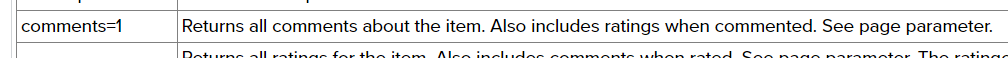


#### Functions

In [11]:
# Getting the ratings of a specific board game (each is in a "comment" div)
def get_ratings(gameid):
    data = {"gameid": [], "user": [], "rating": []}
    page_num = 1
    comments = True
    while comments:
        r = request(f"http://www.boardgamegeek.com/xmlapi2/thing?id={gameid}&ratingcomments=1&page={page_num}")
        soup = BeautifulSoup(r.text, "xml")
        comments = soup("comment")

        for comment in comments:
            data["gameid"].append(gameid)
            data["user"].append(comment['username'])
            data["rating"].append(float(comment['rating']))
            
        if comments:
            if page_num % 10 == 0:
                print(f"Page #{page_num} scraped")
        
        sleep(1)
        page_num += 1

    return pd.DataFrame(data)


def get_ratings_games(df_games):
    df_full = pd.DataFrame(columns=["gameid", "user", "rating"])
    counter = 1
    for gameid in df_games.gameid:
        df = get_ratings(gameid)
        df_full = pd.concat([df_full, df], axis=0)
        print(f"Game #{counter}/{len(df_games)} with id {gameid} added")
        counter += 1
    df_full = df_full.reset_index()
    del df_full['index']   
    return df_full

In [5]:
df = pd.read_csv('csv/1000games.csv')

In [6]:
# split our dataset by years
df19_23 = df.query('year > 2018')
df18 = df.query('year == 2018')
df17 = df.query('year == 2017')
df16 = df.query('year == 2016')
df15 = df.query('year == 2015')

72

In [12]:
df_ratings_2015 = get_ratings_games(df15)

Page #10 scraped
Page #20 scraped
Page #30 scraped
Page #40 scraped
Page #50 scraped
Page #60 scraped
Page #70 scraped
Page #80 scraped
Page #90 scraped
Page #100 scraped
Page #110 scraped
Page #120 scraped
Page #130 scraped
Page #140 scraped
Page #150 scraped
Page #160 scraped
Page #170 scraped
Page #180 scraped
Page #190 scraped
Page #200 scraped
Page #210 scraped
Page #220 scraped
Page #230 scraped
Page #240 scraped
Page #250 scraped
Page #260 scraped
Page #270 scraped
Page #280 scraped
Page #290 scraped
Page #300 scraped
Page #310 scraped
Page #320 scraped
Page #330 scraped
Page #340 scraped
Page #350 scraped
Page #360 scraped
Page #370 scraped
Page #380 scraped
Page #390 scraped
Page #400 scraped
Page #410 scraped
Page #420 scraped
Page #430 scraped
Page #440 scraped
Page #450 scraped
Page #460 scraped
Page #470 scraped
Page #480 scraped
Page #490 scraped
Page #500 scraped
Page #510 scraped
Game #1/72 with id 161936 added
Page #10 scraped
Page #20 scraped
Page #30 scraped
Page #40

In [168]:
df_ratings_2016.to_csv('csv/ratings2016.csv')
df_ratings_2016.head(2)

,gameid,user,rating
0,167791,Interociter,10.0
1,167791,Yldarr,10.0


In [13]:
df_ratings_2015.to_csv('csv/ratings2015.csv')
df_ratings_2015.head(2)

,gameid,user,rating
0,161936,Slyght,10.0
1,161936,Dante_Dark,10.0


### Extract unique users

In [133]:

ratings2017 = pd.read_csv('csv/ratings2017.csv')
ratings2018 = pd.read_csv('csv/ratings2018.csv')
ratings2019_23 = pd.read_csv('csv/ratings_2019-23.csv')

In [155]:
ratings2017_18 = pd.concat([ratings2017, ratings2018])
ratings2017_ = pd.concat([ratings2017_18, ratings2019_23])
#ratings2017_.to_csv('csv/ratings_2017-23.csv')

print(f"In this dataset there are {len(ratings2017_.gameid.unique())} games, {len(ratings2017_.user.unique())} users and {len(ratings2017_)} total votes")

In this dataset there are 411 games, 265263 users and 3357592 total votes


In [192]:
ratings2016_ = pd.concat([ratings2017_, df_ratings_2016])
print(f"In this dataset there are {len(ratings2016_.gameid.unique())} games, {len(ratings2016_.user.unique())} users and {len(ratings2016_)} total votes")

In this dataset there are 482 games, 297930 users and 4372821 total votes


I found a problem that some users rated a game several time, but boardgamegeek.com doesn't save information in chronological order.
So let's consider to average theri ratings

In [193]:
ratings2016_ = ratings2016_.groupby(['gameid', 'user']).agg({'rating': 'mean'}).reset_index()  # remove duplicates and average them - the same gameid and the same user
print("After removing duplicates:")
print(f"In this dataset there are {len(ratings2016_.gameid.unique())} games, {len(ratings2016_.user.unique())} users and {len(ratings2016_)} total votes")

After removing duplicates:
In this dataset there are 482 games, 297930 users and 4366074 total votes


In [194]:
# save to csv
ratings2016_.to_csv('csv/ratings_2016-23.csv')

In [17]:
# adding 2015
ratings2016_ = pd.read_csv('csv/ratings_2016-23.csv')
ratings2016_ = ratings2016_.drop('Unnamed: 0', axis=1)
ratings2016_.head()
len(ratings2016_)

ratings2015_ = pd.concat([ratings2016_, df_ratings_2015])
print(f"In this dataset there are {len(ratings2015_.gameid.unique())} games, {len(ratings2015_.user.unique())} users and {len(ratings2015_)} total votes")

In this dataset there are 554 games, 319893 users and 5363744 total votes


In [18]:
ratings2015_ = ratings2015_.groupby(['gameid', 'user']).agg({'rating': 'mean'}).reset_index()  # remove duplicates and average them - the same gameid and the same user
print("After removing duplicates:")
print(f"In this dataset there are {len(ratings2015_.gameid.unique())} games, {len(ratings2015_.user.unique())} users and {len(ratings2015_)} total votes")

After removing duplicates:
In this dataset there are 554 games, 319893 users and 5357327 total votes


In [23]:
# save to csv
ratings2015_.to_csv('csv/ratings_2015-23.csv', index=False)

In [24]:
# save unique user to csv
users = pd.DataFrame({'name': ratings2015_.user.unique()})
print(f"There are {len(ratings2015_.user.unique())} unique users")
users.to_csv('csv/users.csv', index=False)

There are 319893 unique users


### Reducing database
Let's think of reducing our database
We can only leave users and their ratings, if they rated at least 7 games
- Actually, I had to reduce the databace, because my laptop doesn't have enoght memory

In [25]:
counts = ratings2015_.user.value_counts()  # Calculate value counts for each user
valid_users = counts[counts >= 7].index  # Get the users with counts >= 7
ratings2015_reduced = ratings2015_[ratings2015_.user.isin(valid_users)]  # Filter the ratings based on valid users
ratings2015_reduced.to_csv('csv/ratings_reduced.csv', index=False)

users_reduced = pd.DataFrame({'name': ratings2015_reduced.user.unique()})
users_reduced.to_csv('csv/users_reduced.csv', index=False)
print(f"There are {len(ratings2015_reduced.user.unique())} unique users")

There are 148308 unique users


Now we are ready to train our model

It's done in *recommender_engine.ipynb* file